# Project - Sparkify


## Table of Contents
1. [Overview](#overview)
2. [Load and Clean Dataset](#preprocess)
    1. [Import necessary packages](#package)
    2. [Preprocessing walkthrough](#walkthrough)
3. [Exploratory Data Analysis](#eda)
    1. [Define churn](#churn)
    2. [Explore data](#exdata)
4. [Feature Engineering](#feature_eng)
5. [Modeling](#modeling)
    1. [Metrics](#metrics)
    2. [Logistic Regression](#lr)
    3. [Random Forest](#rf)
    4. [Gradient Boosted Trees](#gbt)
    5. [Support Vector Machine](#svm)
    6. [Model Summary](#model_summary)
    7. [Hyper Params Tuning](#tuning)
    8. [Best Model](#best_model)
    9. [Best Model Metrics](#final_metrics)
    10. [Feature Importance from GBTClassifier](#importance)
6. [Conclusion](#conclusion)
    1. [Summary](#conclusion)
    2. [Reflection](#conclusion)
    3. [Improvement](#conclusion)

## Overview <a id='overview'></a>
Sparkify is a music streaming service like Spotify and Pandora. 

In this project, we are provided with user log data of the Sparkify. The data consists of demographic info, user activities, and timestamps etc. The task is to analyse the data to predict the customers' likely to churn, and thus send them the offers to prevent them from churning.

The model performance is assessed using F1 score to find a balance on both precision and recall, so that we wouldn't miss too many customers who are likely to churn whilst we don't want to waste too much on those who are not likely to churn.

An EDA was performed to create features, and then several machine learning algorithms are explored to fit the best classification model.

The final selected model has a F1 score of 0.867. There is also a short article about this project posted based on the analysis performed.

### Problem Statment

In this work I will attempt to predict the customer churn in advance to prevent the churn by providing offers to the likely cuustomer to churn, using spark (PySpark) and the Gradient boosting models classification. 

In [27]:
# import libraries
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import pandas, matplotlib, and seaborn for visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime for parsing datetime object
import datetime

from time import time

from pyspark.sql import SparkSession

In [28]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Preprocessing walk through <a id='walkthrough'></a>
1. Load the data from json file.
2. Delete NAs.
3. Remove rows with empty as `UserId`.
4. Convert `gender` column to binary numeric column.
5. Convert `ts` and `registration` columns to human readable time stamp format.
6. Create `churn` column, 1 representing user has churned, 0 otherwise. If event `Cancellation Confirmation` observed, we assume the user has churned.

In [29]:
# Extract data
!tar chvfz notebook.tar.gz *

Sparkify-zh.ipynb
Sparkify.ipynb
mini_sparkify_event_data.json
notebook.tar.gz
tar: notebook.tar.gz: file changed as we read it


In [30]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
# checking the column types
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [31]:
# drop NAs
df_valid = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [8]:
df_valid.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

After dropping missing values, I found that missing userId is actually represented by an empty string as shown below. A record with empty userId is probably generated when the user didn't log in or havn't signed up yet, and it contributes little to our analysis afterwards. Therefore, we drop these rows with empty string as userId. 

In [32]:
# inspect 'userId' column
df_valid.select('userId').dropDuplicates().sort('userId').show(5)
# drop empty strings
df_valid = df_valid.filter(df_valid['userId'] != '')

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



## Exploratory Data Analysis <a id='eda'></a>
The EDA is performed on the subset of data as provided.

Visualizing a few reows of the data.

In [8]:
df_valid_pd = df_valid.toPandas()
df_valid_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Define Churn <a id='churn'></a>

I defined a user as `churned` when there's an event called `Cancellation Confirmation` appeared in activity log. This event happens for both paid and free users, meaning that their account associated with the company was terminated at the time. I also kept in track of a downgrade event, labeled as `Submit Downgrade` in activity log.

In [44]:
# create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_valid = df_valid.withColumn("downgrade_event", flag_downgrade_event("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')
df_valid = df_valid.withColumn('downgrade', max('downgrade_event').over(windowval))

# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_valid = df_valid.withColumn('churn_event', flag_churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_valid = df_valid.withColumn('churn', max('churn_event').over(windowval))

In [45]:
# Drop duplicates
df_valid.select(['userId', 'churn', 'downgrade']).dropDuplicates().show(20)

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    0|        0|
|200002|    0|        0|
|   125|    1|        0|
|   124|    0|        0|
|    51|    1|        0|
|     7|    0|        0|
|    15|    0|        0|
|    54|    1|        1|
|   155|    0|        0|
|100014|    1|        0|
|   132|    0|        0|
|   154|    0|        0|
|   101|    1|        0|
|    11|    0|        1|
|   138|    0|        0|
|300017|    0|        0|
|100021|    1|        0|
|    29|    1|        0|
|    69|    0|        0|
|   112|    0|        0|
+------+-----+---------+
only showing top 20 rows



As shown in the table above, the time stamp columns aren't quite intuitive for human to read, so we put a little effort to convert these columns to a more human readable format.

In [46]:
# Adding a time column to the dataframe
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid = df_valid.withColumn('event_time', convert_ts('ts'))
df_valid = df_valid.withColumn('registration_time', convert_ts('registration'))

### Explore Data <a id='exdata'></a>
Exploring the the data to identify patterns.

#### What are the unique activities?

In [14]:
df_valid.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



There are 19 unique activities that a user may have.

#### Customer lifetime statistics

In [15]:
lifetime_pd = df_valid.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime_pd = lifetime_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

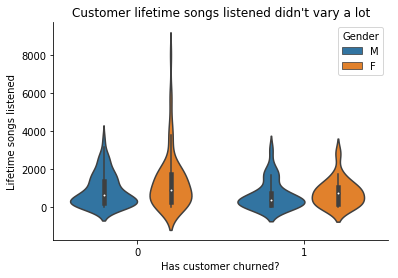

In [16]:
# Create a plot visualize song listing across genders
ax = sns.violinplot(data=lifetime_pd, x='churn', y='NextSong', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs listened didn\'t vary a lot')
sns.despine(ax=ax);

#### Churn pattern between genders

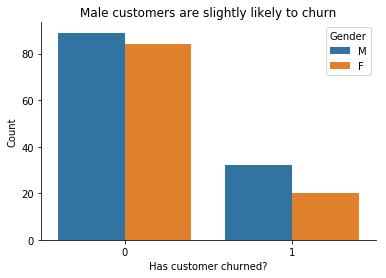

In [18]:
# Plot a bar chart to see if there is any difference in churn b/w male and female
gender_churn_pd = df_valid.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = sns.barplot(x='churn', y='count', hue='gender', data=gender_churn_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Male customers are slightly likely to churn')
sns.despine(ax=ax);

#### Frequency of songs played per session across genders

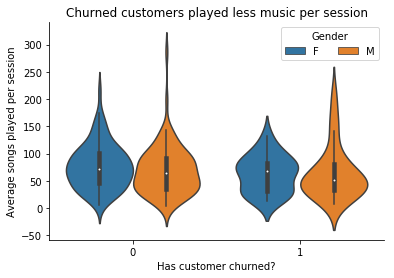

In [19]:
# Does frequency of saongs played by male and females differs?
songs_gender_pd = df_valid.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_gender_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('Churned customers played less music per session')
sns.despine(ax=ax);

#### What is the churning point for the customers?

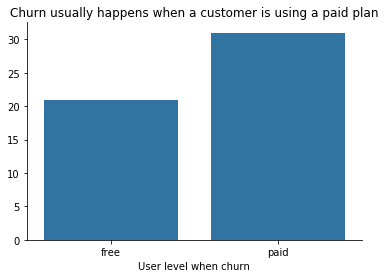

In [20]:
# When does customers churn? Is there any difference b/w paid and free clustomers?
level_pd = df_valid.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

ax = sns.barplot(data=level_pd, x='level', y='count', color=sns.color_palette()[0])
plt.xlabel('User level when churn')
plt.ylabel('')
plt.title('Churn usually happens when a customer is using a paid plan')
sns.despine(ax=ax);

#### Distribution of time since registration for discontinued and active customers

In [21]:
lt_pd = df_valid \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

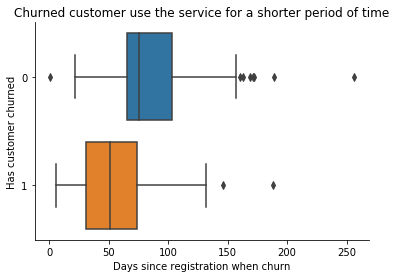

In [22]:
# Create box plots
ax = sns.boxplot(data=lt_pd, y='churn', x='lifetime', orient='h')
plt.xlabel('Days since registration when churn')
plt.ylabel('Has customer churned')
plt.title('Churned customer use the service for a shorter period of time')
sns.despine(ax=ax);

## Feature Engineering <a id='feature_eng'></a>
So far we've familiarized ourselves with the data, now let's create features for the modeling.

##### 1. The first feature considered is the time length since the user registered. It may reflect the user engagement, loyality, and etc.

In [33]:
# Time since registration
f1 = df_valid \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
f1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



##### 2. The second feature we considered is the total number of songs listened. The more songs the user listened, the more time the user spent with our service, the deeper engagement the user have, leading to less chance to churn

In [34]:
# Total songs listened
f2 = df_valid \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
f2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



##### 3. Third features is number of thumbs up. It would reflect two perspectives, our service quality and user engagement.

In [35]:
# Number of Thumbs-Up/Down
f3 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
f3.describe().show()


+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



##### 4. Fourth features is number of thumbs down. It may reflect two perspectives, our service quality and user engagement.

In [36]:
f4 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
f4.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



##### 5. The fifth feature is the number of songs added to the playlist, and it functioned as about the same as the 3rd and 4th feature.

In [37]:
# Number of songs added to playlist
f5 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')
f5.describe().show()

+-------+------------------+-----------------+
|summary|            userID|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



##### 6. The sixth feature is the number of friends added.

In [38]:
# Number of friends added
f6 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend') 
f6.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



##### 7. The seventh feature is the length of listening, serving the same objective as the total number of songs listened, but in a time perspective.

In [39]:
# Total length of listening
f7 = df_valid \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
f7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



##### 8. The eighth feature is the average number of songs listened per session.

In [40]:
# Number of songs listened per session
f8 = df_valid.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
f8.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



##### 9. The ninth feature is the gender, as we want to include some demographic information about the user, and there are differences between genders in terms of chance to churn.

In [41]:
# Gender
f9 = df_valid \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
f9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



##### 10. The tenth feature is the number of artists listened.

In [42]:
# Number of artists listened
f10 = df_valid \
    .filter(df_valid.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
f10.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



#### FInally creating the Churn label as a target variable

In [47]:
# Churn label
label = df_valid \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



#### Merging all features and label together.

In [48]:
# Construct 
data = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .join(f8,'userID','outer') \
    .join(f9,'userID','outer') \
    .join(f10,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|       listen_time|  avg_songs_played|gender|artist_count|label|
+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|  55.6436574074074|        381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     1|         252|    0|
| 70.07462962962963|        474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|         339|    0|
| 71.31688657407408|         11|           0|             0|              0|         0|2089.1131000000005|               8.0|     0|           8|    1|
|131.55591435185184|       4825|         171|            41|            118|        74|1

## Modeling <a id='modeling'></a>
We have created the features based on our EDA to predict the churn. In this section we'll develop classification models to predict the churn.

### Metrics <a id='metrics'></a>
To assess the model performance, F-1 score has been selected as an evaluation metrics. The reason to use F-1 score here is, because it gives a simple measure of the precision (whether we send offer to the right person) and recall (whether we miss one that we should’ve sent the offer) of the model. We want to identify those who are likely to churn and give them some special offers in trying to keep the customer, but at the same time, we do not want to send too many offers (most likely a monetary incentive) to those who are not as likely to churn and therefore wasting money and resources.

##### First we need to vectorize our features.

In [49]:
# Vector assembler
cols = ["lifetime", "total_songs", "num_thumb_up", \
          'num_thumb_down','add_to_playlist','add_friend','listen_time','avg_songs_played', \
        'gender', 'artist_count']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

In order to avoid one feature with larger scale dominant the whole model, we standardize the features by taking off the mean and divided by the standard deviation of each feature.

In [50]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

Then we split the data into train, validation, and test sets by calling `randomSplit` method twice. We can also conduct a stratified sampling as our label is pretty skewed.

In [51]:
# train test split
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

#### Logistic Regression <a id='lr'></a>
Developing a logistic regression model to predict the probabaility of churn.

In [51]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [52]:
start = time()
cvModel_lr = crossval_lr.fit(train)
end = time()
cvModel_lr.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 550.466591835022 seconds


In [53]:
results_lr = cvModel_lr.transform(validation)

In [54]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048


#### Random Forest <a id='rf'></a>
Logistic Regression provides a descent accuracy. Let's try out an ensemble models to see if we can improve the accuracy by sacrificing a lttle on the model interpretability as our action item would be arround the predicted likelihood of the customer churn, knowing the eaxact reason for churn doen't add much value.

In [37]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [38]:
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
cvModel_rf.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 693.9701433181763 seconds


In [39]:
results_rf = cvModel_rf.transform(validation)

In [40]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048


#### Gradient Boosted Trees <a id='gbt'></a>
Let's see if boosting ensemble models can further improve the model performance over randomforest.

In [55]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [56]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
cvModel_gbt.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 1123.4195115566254 seconds


In [57]:
results_gbt = cvModel_gbt.transform(validation)

In [58]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.8
F-1 Score:0.7703703703703705


#### Support Vector Machine <a id='svm'></a>
Support vector machine is another advanced machine learning method which works very well for the multidimensional data, if we can find the right kernel function to transform the feature space in a right lattent space.

In [38]:
# initialize classifier
svm = LinearSVC(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [39]:
start = time()
cvModel_svm = crossval_svm.fit(train)
end = time()
cvModel_svm.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 809.3359849452972 seconds


In [40]:
results_svm = cvModel_svm.transform(validation)

In [41]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.8666666666666667
F-1 Score:0.8047619047619048


#### Model summary: <a id='model_summary'></a>
* The logistic regression model has a accuracy of: 0.867, and F1 score of: 0.805, using 550 seconds on our server.
* The random forest model has a accuracy of: 0.867, and F1 score of: 0.805, using 694 seconds on our server.
* The gradient boosted trees model has a accuracy of: 0.8, and F1 score of: 0.770, using 1123 seconds on our server.
* The support vector machine model has a accuracy of: 0.867, and F1 score of: 0.805, using 809 seconds on our server.

On the sample data, we obsevrved that logistic regression, random forest and SVM has the same accuracy and logistic regression take the minimum time. Moreover logistic regression has better explanability, hence I am selecting logistic regression as the best model.


#### Hyperparams tunning <a id='tuning'></a>

We use grid search to fine tune our Random Forest Classifier. We mainly tuned two parameters,elastic net regularization. elasticNetParam corresponds to α and regParam corresponds to λ

In [53]:
# Extracting the co-efficient for Logistic regression
# Re-run the function for Logistic Regression

dt = LogisticRegression(maxIter=10)
paramGrid = ParamGridBuilder() \
    .addGrid(dt.elasticNetParam,[0.0,0.05,0.1]) \
    .addGrid(dt.regParam,[0.0,0.5,1]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)
cvModel_dt.avgMetrics
    
results_gbt = cvModel_dt.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
print('Metrics for Logistic Regression model:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Metrics for Logistic Regression model:
Accuracy: 0.7794117647058824
F-1 Score:0.7600045496767834


Even with additional parameters tuning the accuracy and F1 score does not improve. This means that the model is not multicolinear and categorical variables don't need any regularization.

In [65]:
cvModel_dt.bestModel.coefficientMatrix

DenseMatrix(1, 10, [-1.0157, -0.0532, -0.7903, 1.1316, -0.2258, -0.9021, -0.0642, -0.1037, -0.0679, 0.3193], 1)

In [66]:
feature_importance = cvModel_dt.bestModel.coefficientMatrix
feature_importance

DenseMatrix(1, 10, [-1.0157, -0.0532, -0.7903, 1.1316, -0.2258, -0.9021, -0.0642, -0.1037, -0.0679, 0.3193], 1)

In [67]:
coeff_dict = {}

In [69]:
coeff_dict = {
'time_since_reg':[feature_importance[0,0]],
'toltal_songs_listen': [feature_importance[0,1]],
'nThumbs_up': [feature_importance[0,2]],
'nThumbs_down' : [feature_importance[0,3]],
'nSongs_added': [feature_importance[0,4]],
'nFriends_added' : [feature_importance[0,5]],
'total_length_listen' : [feature_importance[0,6]],
'nSongs_per_person' : [feature_importance[0,7]],
'Gender' : [feature_importance[0,8]],
'nArtists_listen' : [feature_importance[0,9]]
    }

coeff_dict

{'time_since_reg': [-1.0156796110104629],
 'toltal_songs_listen': [-0.053195658091450486],
 'nThumbs_up': [-0.79029711857350804],
 'nThumbs_down': [1.1316461507607019],
 'nSongs_added': [-0.22579655329651349],
 'nFriends_added': [-0.9021352846137094],
 'total_length_listen': [-0.064216123560837779],
 'nSongs_per_person': [-0.10369374431899335],
 'Gender': [-0.067945946637720162],
 'nArtists_listen': [0.3192758691528047]}

In [70]:
#Converting the dictionary to a dataframe
df_coeff = pd.DataFrame.from_dict(coeff_dict,orient='index',columns = ["coeff"])
df_coeff

,coeff
time_since_reg,-1.015680
toltal_songs_listen,-0.053196
nThumbs_up,-0.790297
nThumbs_down,1.131646
nSongs_added,-0.225797
nFriends_added,-0.902135
total_length_listen,-0.064216
nSongs_per_person,-0.103694
Gender,-0.067946
nArtists_listen,0.319276


In [71]:
#renaming the index column
df_coeff.index.name = 'Variable'
df_coeff

,coeff
Variable,
time_since_reg,-1.015680
toltal_songs_listen,-0.053196
nThumbs_up,-0.790297
nThumbs_down,1.131646
nSongs_added,-0.225797
nFriends_added,-0.902135
total_length_listen,-0.064216
nSongs_per_person,-0.103694
Gender,-0.067946


In [72]:
# Converting the importance into a %
df_coeff["importance"] =df_coeff["coeff"].abs()*100 / df_coeff["coeff"].max()
df_coeff

,coeff,importance
Variable,,
time_since_reg,-1.015680,89.752403
toltal_songs_listen,-0.053196,4.700732
nThumbs_up,-0.790297,69.836063
nThumbs_down,1.131646,100.000000
nSongs_added,-0.225797,19.952929
nFriends_added,-0.902135,79.718849
total_length_listen,-0.064216,5.674576
nSongs_per_person,-0.103694,9.163089
Gender,-0.067946,6.004169


In [73]:
#resetting teh index and sorting
df = df_coeff.reset_index()
df = df.sort_values('importance',ascending = False)
df

,Variable,coeff,importance
3,nThumbs_down,1.131646,100.000000
0,time_since_reg,-1.015680,89.752403
5,nFriends_added,-0.902135,79.718849
2,nThumbs_up,-0.790297,69.836063
9,nArtists_listen,0.319276,28.213401
4,nSongs_added,-0.225797,19.952929
7,nSongs_per_person,-0.103694,9.163089
8,Gender,-0.067946,6.004169
6,total_length_listen,-0.064216,5.674576
1,toltal_songs_listen,-0.053196,4.700732


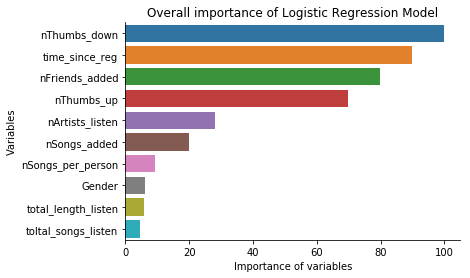

In [74]:
#horizontal bar plot of importance
ax = sns.barplot(data=df, y='Variable', x='importance', orient='h')
plt.xlabel('Importance of variables')
plt.ylabel('Variables')
plt.title('Overall importance of Logistic Regression Model')
sns.despine(ax=ax);

#### Observations:
 - It is evident that the count of artists that a user listens to is the most important variable that will inofrm us the likelihookd of churn of a user 
 - Hence, the top 5 important features are:
     - Number of Thumbs down
     - Time Since Registration
     - Number of Friends addedd
     - Number of thumbs up
     - Number of artists' listented

# Conclusion 
**Summary**
In this notebook, we have developed a model to predict customer churn. The data is cleaned with all missing data .
 - rows with no userId
 - converted timestamp
 - converted gender to binary numeric column
 - 10 features were built for our model. 

We selected 4 models: 
 1. Losistic Regression
 2. Random forest
 3. Gradient Boost
 4. Support Vector Machine

Based on F1 score, Accuracy metrics and model run time, we selected logistic regression as the best model, and the same was tuned. However the regularization doesn't improve the model.

The top 5 important features are:
 1. Number of Thumbs down
 2. Time Since Registration
 3. Number of Friends addedd
 4. Number of thumbs up
 5. Number of artists' listented

**Reflection**
This project provides an opportunity for me to learn Spark. The ability to distribute data, run queries and build necessary conclusions. The ability to run SQL and ML algorithms beyond pandas, sklearn

**Improvement**
The features provide a good understanding of the reasons for churn. However, if we can interact with end users / owner of Sparkify app to deign necessary hypotheses and test them, we can improve the model by buidling more relevant features 
Also, the model could be imporved if run on the entire 12GB data